In [2]:

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from math import radians, sin, cos, sqrt, atan2
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
sns.set(font_scale=1.3)

In [3]:
train = pd.read_csv('Part-1.csv').drop('Unnamed: 0', axis=1)
test = pd.read_csv('Part-2.csv').drop('Unnamed: 0', axis=1)

In [4]:
data = pd.concat([train, test]).reset_index().drop('index', axis=1)
del train
del test

In [5]:
data['full_name'] = data['first'] + ' ' + data['last']
data.drop(['first', 'last', 'trans_num', 'unix_time'], axis=1, inplace=True)
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['year'] = data['trans_date_trans_time'].dt.year
data['month'] = data['trans_date_trans_time'].dt.month
data['day'] = data['trans_date_trans_time'].dt.day
data['hour'] = data['trans_date_trans_time'].dt.hour
data['day_of_week'] = data['trans_date_trans_time'].dt.day_name()
data['is_weekend'] = (data['trans_date_trans_time'].dt.weekday // 5).map({0: 'No', 1: 'Yes'})
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
data['month'] = data['month'].apply(lambda x: months[x - 1])
def get_credit_card_type(card_number):
    card_number = str(card_number)
    if card_number[0] == '4':
        return 'Visa'
    elif card_number[0] == '5' or card_number[0] == '2':
        return 'MasterCard'
    elif card_number[0] == '3':
        return 'American Express'
    elif card_number[0] == '6':
        return 'Discover'
    else:
        return 'Unknown'
data['cc_type'] = data['cc_num'].apply(get_credit_card_type)
freq = data['cc_num'].value_counts()
data['category'] = data['category'].apply(lambda x: x.title().replace('_', ' '))
data['gender'] = data['gender'].map({'F': 'Female', 'M': 'Male'})
data['address'] = data['street'] + ', ' + data['city'] + ', ' + data['state'] + ' ' + data['zip'].apply(str)
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    distance = 2 * R * atan2(sqrt(a), sqrt(1 - a))
    return distance
data['distance'] = data.apply(lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)
data.drop(['lat', 'long', 'merch_lat', 'merch_long'], axis=1, inplace=True)
data['dob'] = pd.to_datetime(data['dob'])
data['age'] = np.ceil((data['trans_date_trans_time'] - data['dob']).dt.days / 365).astype(int)
data.drop('trans_date_trans_time', axis=1, inplace=True)
data.drop('dob', axis=1, inplace=True)
def age_interval(age):
    if 14 <= age < 30:
        return '14 to 30'
    elif 30 <= age < 45:
        return '30 to 45'
    elif 45 <= age < 60:
        return '45 to 60'
    elif 60 <= age < 75:
        return '60 to 75'
    else:
        return 'Older than 75'
    
data['age_interval'] = data['age'].apply(age_interval)
data.drop(['cc_num', 'merchant', 'street', 'city', 'state', 'zip', 'year'], axis=1, inplace=True)
data['gender'] = data['gender'].map({'Female': 0, 'Male': 1})
data['is_weekend'] = data['is_weekend'].map({'No': 0, 'Yes': 1})
skewed = ['amt', 'city_pop']
data[skewed] = data[skewed].apply(np.log1p)
oe = OrdinalEncoder()
columns_to_encode = ['category', 'job', 'address', 'month', 'day_of_week', 'cc_type', 'full_name', 'age_interval']
data[columns_to_encode] = oe.fit_transform(data[columns_to_encode])


In [ ]:
# Save the OrdinalEncoder model
import joblib
joblib.dump(oe, 'encodermodel.joblib')

In [6]:
X = data.drop('is_fraud', axis=1)
y = data['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
def train_rf(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(max_depth=12, n_estimators=100, random_state=234)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    return rf,[accuracy, recall, precision, f1]

In [8]:
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=19)
X_undersampled, y_undersampled = rus.fit_resample(X_train, y_train)

In [9]:
rf,result1 = train_rf(X_undersampled, y_undersampled, X_test, y_test)
result1

[0.9970848550120249, 0.8517169614984391, 0.673108552631579, 0.7519522278364722]

In [10]:
importances = rf.feature_importances_

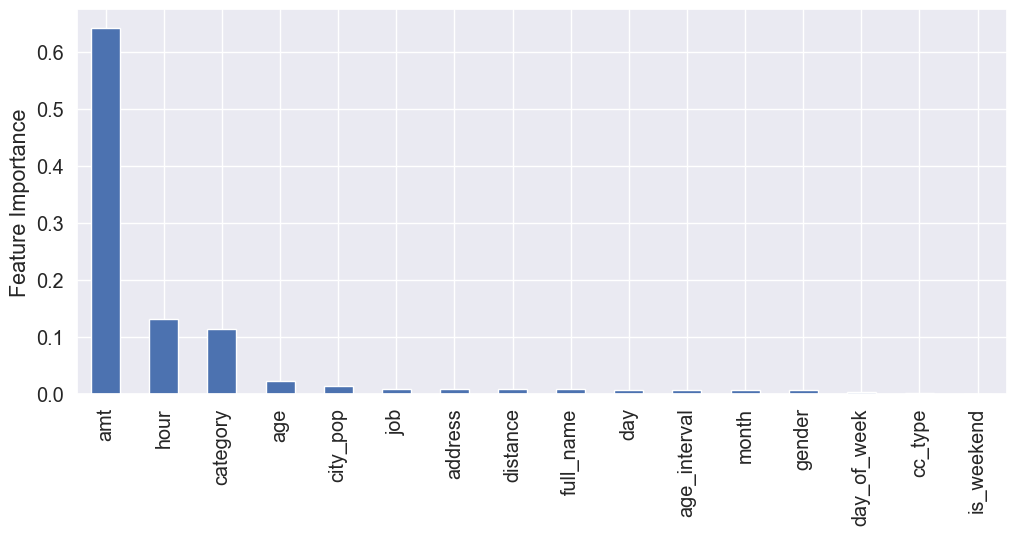

In [11]:
forest_importances = pd.Series(importances, index=X_train.columns)
fig, ax = plt.subplots(figsize=(12, 5))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_ylabel("Feature Importance")
plt.show()

In [12]:
less_info = ['is_weekend', 'cc_type', 'gender', 'day_of_week']

In [13]:
X_undersampled.drop(less_info, axis=1, inplace=True)
X_test.drop(less_info, axis=1, inplace=True)

In [14]:
models_results = pd.DataFrame(columns=['Recall', 'Precision', 'F1', 'AUC'])

In [15]:
def evaluate_model(target, predicted, y_score, can_auc=True):
    accuracy = accuracy_score(target, predicted)
    precision = precision_score(target, predicted)
    recall = recall_score(target, predicted)
    f1 = f1_score(target, predicted)

    auc = np.NaN
    if can_auc:
        auc = metrics.roc_auc_score(target, y_score)

    print('Accuracy:', round(accuracy, 2))
    print('Precision:', round(precision, 2))
    print('Recall:', round(recall, 2))
    print('F1 Score:', round(f1, 2))
    print('AUC:', auc)

    return [round(recall, 2), round(precision, 2), round(f1, 2), auc]


In [16]:
def train_model(model, X_train, y_train, X_test, y_test, auc_plot=True, scale=True):
    if scale:
        ss = StandardScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.fit_transform(X_test)
    
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    y_score_train = np.NaN
    y_score_test = np.NaN
    if auc_plot:
        y_score_train = model.predict_proba(X_train)[:, 1]
        y_score_test = model.predict_proba(X_test)[:, 1]
    
    print('-------------- Training Evaluation --------------')
    models_results.loc[type(model).__name__ + ' Trainig'] = evaluate_model(y_train, y_pred_train,
                                                                           y_score_train, can_auc=auc_plot)
    print('--------------         END         --------------')
    print()
    print()
    print('-------------- Testing Evaluation --------------')
    models_results.loc[type(model).__name__ + ' Testing'] = evaluate_model(y_test, y_pred_test,
                                                                           y_score_test, can_auc=auc_plot)
    print('--------------         END         --------------')

In [17]:

from sklearn.metrics import  roc_auc_score

def train_rf(X_train, y_train, X_test, y_test, threshold=0.5):
    rf = RandomForestClassifier(max_depth=12, n_estimators=100, random_state=234)
    rf.fit(X_train, y_train)
    
    # Obtain predicted probabilities
    y_pred_proba = rf.predict_proba(X_test)[:, 1]
    
    # Adjust classification based on the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)  # Calculate AUC score
    
    return rf, [accuracy, recall, precision, f1, auc], y_pred_proba

# Train the RF model with the modified function
rf, result1, y_pred_proba = train_rf(X_undersampled, y_undersampled, X_test, y_test)

# Choose a threshold based on your preference (e.g., maximizing precision)
custom_threshold = 0.7  # Adjust this value as needed

# Classify instances based on the chosen threshold
y_pred_custom_threshold = (y_pred_proba >= custom_threshold).astype(int)

# Evaluate the performance with the new threshold
precision_custom_threshold = precision_score(y_test, y_pred_custom_threshold)
recall_custom_threshold = recall_score(y_test, y_pred_custom_threshold)
f1_custom_threshold = f1_score(y_test, y_pred_custom_threshold)
auc_custom_threshold = roc_auc_score(y_test, y_pred_proba)

print("Results with Custom Threshold:")
print("Precision:", precision_custom_threshold)
print("Recall:", recall_custom_threshold)
print("F1 Score:", f1_custom_threshold)
print("AUC Score:", auc_custom_threshold)

# Update models_results with the results using the custom threshold
models_results.loc['CustomThreshold_RF Testing'] = [recall_custom_threshold, precision_custom_threshold, f1_custom_threshold, auc_custom_threshold]


Results with Custom Threshold:
Precision: 0.8345205479452055
Recall: 0.7924037460978148
F1 Score: 0.8129170002668802
AUC Score: 0.9948531096232416


In [18]:
dtree = DecisionTreeClassifier(random_state=2020)
train_model(dtree, X_undersampled, y_undersampled, X_test, y_test, scale=False)

-------------- Training Evaluation --------------
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC: 1.0
--------------         END         --------------


-------------- Testing Evaluation --------------
Accuracy: 0.99
Precision: 0.33
Recall: 0.92
F1 Score: 0.48
AUC: 0.9557988172603643
--------------         END         --------------


In [32]:
from sklearn.ensemble import VotingClassifier


# Create the ensemble classifier with weights
ensemble_clf = VotingClassifier(estimators=[
    ('RandomForest', rf),
    ('DecisionTree', dtree)
], voting='soft', weights=[2.9,1])

# Train the ensemble model
train_model(ensemble_clf, X_undersampled, y_undersampled, X_test, y_test, scale=False)


-------------- Training Evaluation --------------
Accuracy: 1.0
Precision: 1.0
Recall: 0.96
F1 Score: 0.98
AUC: 0.9999673404155359
--------------         END         --------------


-------------- Testing Evaluation --------------
Accuracy: 1.0
Precision: 0.61
Recall: 0.9
F1 Score: 0.73
AUC: 0.9952681518049198
--------------         END         --------------


In [33]:
tests = models_results[models_results.index.str.contains('Testing')]
tests

,Recall,Precision,F1,AUC
CustomThreshold_RF Testing,0.792404,0.834521,0.812917,0.994853
DecisionTreeClassifier Testing,0.920000,0.330000,0.480000,0.955799
VotingClassifier Testing,0.900000,0.610000,0.730000,0.995268


In [21]:
import joblib
# Save the ensemble model to a .pkl file
model_filename = 'ensemble_model.pkl'
joblib.dump(ensemble_clf, model_filename)

['ensemble_model.pkl']